# Routing Optimisation for Aeronautical Networks

## Introduction

To enable internet connectivity for passengers onboard, it is necessary to improve the data packet routing path for airplanes travelling over the North Atlantic. End-to-end latency and data transfer rate are the two major criteria on which the optimization is based. When comparing end-to-end latency and end-to-end data transmission rate, the end-to-end latency is the total of all delays imposed by each link, while the data transmission rate is the lowest transmission rate of each link in the routing path.

The distance between the two communicating airplanes, affects the data transmission rate of a link. 

There are two optimization problems to be solved:

1. Single-Objective Optimization: the goal of this is to find a routing path with the highest end-to-end data transmission rate possible for each aircraft that can access either Heathrow airport(LHR) or Newark Liberty International Airport(EWR). Assuring that the plane can connect to either of the two ground stations while maximizing data transmission rate is the goal.

2. Multiple-Objective Optimization: the goal of this is to find a routing path with the highest end-to-end data transmission rate and the lowest end-to-end delay for each aircraft that can access either Heathrow airport (LHR) or Newark Liberty International Airport(EWR). The goal is to strike a compromise between lowering end-to-end latency and increasing data transfer rate. The answer will be the routing strategy that bests both goals.


                                       




---



## Methodology

1. The execution of the project started from importing functionality from the 
OR-Tools library which was used to solve the optimization problem. The dataset was loaded with the python pandas library which is a powerful data manipulation and analysis library.

2. A calcDistance() function was created to determine the distance in kilometers between two points on Earth. It is intended to accept two location objects, location A and location B, both of which are presumptively equipped with properties for altitude, latitude, and longitude. The function uses these properties to transform each location's latitude, longitude, and altitude into 3D Cartesian coordinates.

3. The details(altitude, longitude and latitude) of the ground station to be was added to the flight data and the distance matrix function was created. The distance matrix funtion calculate the distance between each pair of airplane using the calcDistance function already created in the step 2 above.

4. A function was created to convert the distance between each airplane to transmission rate accordingly.

5. To finally solve the problem, a main function to create a data model using the "create_data_model()" function, which stores the data for the problem, such as the distance matrix and the starting and ending nodes for each vehicle. Then, it creates an instance of the RoutingIndexManager, which is used to create the routing model. Next, a transit callback function waas created to returns the distance between two nodes. This callback function was set as the arc cost evaluator for all the vehicles and adds a dimension for distance constraint. After that, the built-in solver of or-tools was used to find the optimal routes between starting and ending nodes of each vehicle. Then it calls the "print_solution()" function to print the solution, which includes the objective value, distance of the route and the end-to-end transmission rate of each route which is the minimum transmission rate of each link in the routing path. It also prints the maximum distance of the routes and the maximum end-to-end transmission rate of all the routes.



## Visualizations

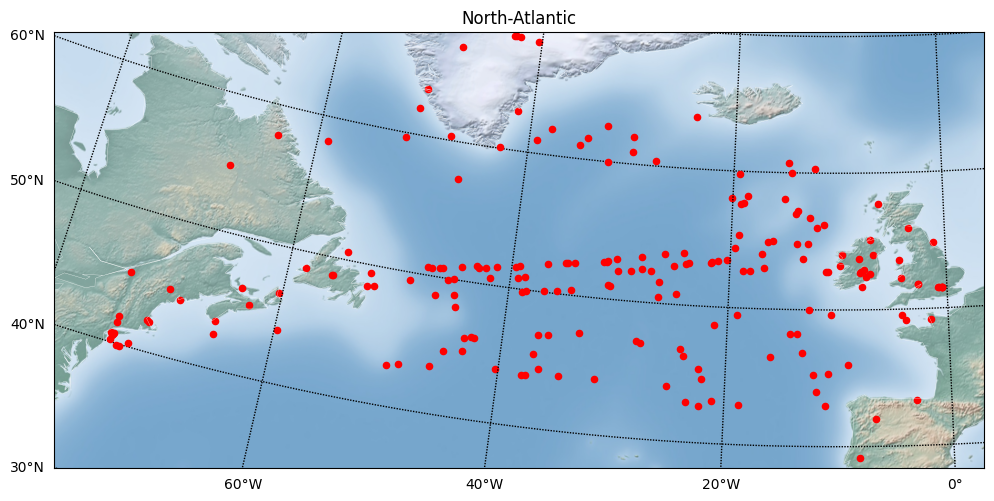

In [3]:
import pandas as pd
flight_data = pd.read_csv('NA_13_Jun_29_2018_UTC13 (1).csv') # load csv file
LatitudeData = flight_data.Latitude.copy()
LongitudeData = flight_data.Longitude.copy()
AltitudeData = flight_data.Altitude.copy()

min_lat = 30
max_lat = 70
min_lon = -75
max_lon = 5
fig = plt.figure(figsize=(12, 9))
ax = plt.axes()
m = Basemap(projection='eqdc',  # Equidistant Conic Projection 
            llcrnrlat=min_lat,
            urcrnrlat=max_lat,
            llcrnrlon=min_lon,
            urcrnrlon=max_lon,
            lat_1=10,lat_2=20,lat_0=50,lon_0=-10
           )
# More projection methods can be see from https://matplotlib.org/basemap/users/mapsetup.html# 

m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines
m.shadedrelief(scale=0.5)
m.drawparallels(np.arange(-90, 90, 10), labels=[1, 0, 0, 0], zorder=1)
m.drawmeridians(np.arange(-180, 180, 20), labels=[0, 0, 0, 1], zorder=2)


# Set airport locations
LHR = [51.47, -0.45, 24.91]   # (Latitude, Longitude, Altitude)
EWR = [40.69, -74.17, 2.66]   # (Latitude, Longitude, Altitude)
latitudes = [LHR[0],EWR[0]]
longitudes = [LHR[1],EWR[1]]
altitudes = [LHR[2],EWR[2]]
lats_with_head = LatitudeData
lons_with_head = LongitudeData

lats = LatitudeData
lons = LongitudeData
# compute n# make up some data for scatter plot
x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, 20, marker='o', color='Red') 
#text_airport_LHR = ax.text(0, 0, '', c='b', zorder=5, bbox=dict(facecolor='w', alpha=0.5, edgecolor='w'))
#text_airport_EWR = ax.text(0, 0, '', c='b', zorder=5, bbox=dict(facecolor='w', alpha=0.5, edgecolor='w'))
#text_airport_LHR.set_position([x[0]*1.01, y[0]*1.01])
#text_airport_EWR.set_position([x[1]*1.02, y[1]*1.02])
#text_airport_LHR.set_text('LHR')
#text_airport_EWR.set_text('EWR')


plt.title("North-Atlantic")
plt.show()



## Implementation of the solution to the problems

In [ ]:
import math
from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


In [ ]:
import pandas as pd
flight_data = pd.read_csv('NA_13_Jun_29_2018_UTC13 (1).csv') # load csv file
flight_data.head(10)

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.0,50.9,-38.7
1,AA109,1530277200,33000.0,60.3,-12.2
2,AA111,1530277200,39000.0,52.7,-18.1
3,AA113,1530277200,37000.0,43.0,-11.1
4,AA151,1530277200,36400.0,47.0,-27.7
5,AA198,1530277200,0.0,39.9,-73.0
6,AA199,1530277200,37000.0,53.1,-23.8
7,AA204,1530277200,0.0,40.2,-73.6
8,AA209,1530277200,38000.0,58.2,-59.0
9,AA221,1530277200,34000.0,59.7,-51.8


In [ ]:
#Using only first 25 samples of the dataset
data_partitioned20 = flight_data.head(30).copy()

In [ ]:
## Function to calculate distances
def calcDistance(location_A, location_B):
    R_E = 6371000   # The radius of earth

    L_a = location_A.Altitude * 0.3048  # Obtain altitude and convert from feet to meters
    L_b = location_B.Altitude * 0.3048  # Obtain altitude and convert from feet to meters

    Theta_a = location_A.Latitude # get feature 'latitude'
    Theta_b = location_B.Latitude # get feature 'latitude'

    Varphi_a = location_A.Longitude # get feature 'longitude'
    Varphi_b = location_A.Longitude # get feature 'longitude'

# The below code is to convert (altitude, latitude, longitude) to 3D Cartesian coordinates
    p_xa = (R_E + L_a) * math.cos(math.radians(Theta_a)) * math.cos(math.radians(Varphi_a))  # Eq. (15)
    p_ya = (R_E + L_a) * math.cos(math.radians(Theta_a)) * math.sin(math.radians(Varphi_a))  # Eq. (16)
    p_za = (R_E + L_a) * math.sin(math.radians(Theta_a))  # Eq. (17)

    p_xb = (R_E + L_b) * math.cos(math.radians(Theta_b)) * math.cos(math.radians(Varphi_b))  # Eq. (15)
    p_yb = (R_E + L_b) * math.cos(math.radians(Theta_b)) * math.sin(math.radians(Varphi_b))  # Eq. (16)
    p_zb = (R_E + L_b) * math.sin(math.radians(Theta_b))  # Eq. (17)

# calculate the distance between aircraft a and aircraft b
    d_ab_in_m = math.sqrt((abs(p_xa - p_xb)) ** 2 + (abs(p_ya - p_yb)) ** 2 + (abs(p_za - p_zb)) ** 2)
    d_ab_in_km = d_ab_in_m/1000
    #return distance in kilometers
    return d_ab_in_km
    

In [ ]:
#Adding LHR(81.73feet, 51.4700, 0.4543) and EWR to flight_data
data_partitioned20.loc[len(data_partitioned20)] = ['LHR',1530277200,81.73,51.4700,0.4543]
#data_partitioned20.loc[len(data_partitioned20)] = ['EWR',1530277200,8.72,40.6895,74.1745]
data_partitioned20

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.00,50.90,-38.7000
1,AA109,1530277200,33000.00,60.30,-12.2000
2,AA111,1530277200,39000.00,52.70,-18.1000
3,AA113,1530277200,37000.00,43.00,-11.1000
4,AA151,1530277200,36400.00,47.00,-27.7000
5,AA198,1530277200,0.00,39.90,-73.0000
6,AA199,1530277200,37000.00,53.10,-23.8000
7,AA204,1530277200,0.00,40.20,-73.6000
8,AA209,1530277200,38000.00,58.20,-59.0000
9,AA221,1530277200,34000.00,59.70,-51.8000


### Q1a) Routing Path To  Heathrow airport (LHR)

In [ ]:
flight_data.loc[len(flight_data)] = ['LHR',1530277200,81.73,51.4700,0.4543]
#flight_data.loc[len(flight_data)] = ['EWR',1530277200,8.72,40.6895,74.1745]
flight_data

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.00,50.90,-38.7000
1,AA109,1530277200,33000.00,60.30,-12.2000
2,AA111,1530277200,39000.00,52.70,-18.1000
3,AA113,1530277200,37000.00,43.00,-11.1000
4,AA151,1530277200,36400.00,47.00,-27.7000
...,...,...,...,...,...
212,UA973,1530277200,33000.00,61.00,-39.3000
213,UA975,1530277200,36000.00,50.50,-26.4000
214,UA986,1530277200,36000.00,60.00,-32.2000
215,UA988,1530277200,36100.00,52.70,-18.8000


In [ ]:
distance_matrix_part = []
#Creating distance matrix for partitioned data
for i in range(len(data_partitioned20)):
    distances = [calcDistance(data_partitioned20.iloc[i], data_partitioned20.iloc[x]) for x in range(len(data_partitioned20))]
    distance_matrix_part.append(distances)
len(distance_matrix_part)

31

In [ ]:
distance_matrix_full = []
#Creating distance matrix for flight data
for i in range(len(flight_data)):
    distances = [calcDistance(flight_data.iloc[i], flight_data.iloc[x]) for x in range(len(flight_data))]
    distance_matrix_full.append(distances)
len(distance_matrix_full)

217

In [ ]:
Transmission_dict = {500:31.895, 400:43.505, 300:52.857,
                     190:63.970, 90:77.071,
                    35:93.854, 5.56:119.130}

def getTransmission(distance):
    
    if (distance>500):
        transmissionRate = 31.895
    elif (400<distance<=500):
        transmissionRate = 43.505
    elif (300<distance<=400):
        transmissionRate = 52.875
    elif (190<distance<=300):
        transmissionRate = 63.970
    elif (90<distance<=190):
        transmissionRate = 77.071
    elif (35<distance<=90):
        transmissionRate = 93.854
    elif (5.56<distance<=35):
        transmissionRate = 119.130
    else:
        transmissionRate = 119.130
        
    return transmissionRate

In [ ]:
STARTS = [i for i in range(5)]
ENDS = [216 for i in STARTS]
print(STARTS)
print(ENDS)
len(STARTS) == len(ENDS)

[0, 1, 2, 3, 4]
[216, 216, 216, 216, 216]


True

In [ ]:
"""Algorithm to get maximum transmission rate"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_full
    data['num_vehicles'] = len(STARTS)
    data['starts'] = STARTS
    data['ends'] = ENDS
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    #Defining an empty list for storing transmission rates for each aiplane
    transmissionRates = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for Airplane {}:\n'.format(vehicle_id)
        route_distance = 0
        route_transmissionRates = []#transmission rate for each link will be stored here
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            distanceBtwLinks = routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_distance += distanceBtwLinks
            #if no optimal route between two nodes, calc distance manually to get transmission rates
            if distanceBtwLinks == 0:
                dist = calcDistance(flight_data.iloc[vehicle_id], flight_data.iloc[216])
                route_distance+=dist
                route_transmissionRates.append(getTransmission(dist))
            else:
                route_transmissionRates.append(getTransmission(distanceBtwLinks))
           
        #The end-to-end data transmission rate is the minimum transmission rate of each link in the routing path. 
        end2end_transmissionRate = min(route_transmissionRates)
        transmissionRates.append(end2end_transmissionRate)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        plan_output += 'end2end transmission rate of the route: {}mb\n'.format(end2end_transmissionRate)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))
    print('Maximum end to end transmission rate: {}mb'.format(max(transmissionRates)))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting objective heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 1708567
Route for Airplane 0:
 0 -> 216
Distance of the route: 64.53957434356685km
end2end transmission rate of the route: 93.854mb

Route for Airplane 1:
 1 ->  150 ->  188 ->  211 ->  23 ->  212 ->  169 ->  148 ->  68 ->  126 ->  149 ->  159 ->  76 ->  110 ->  200 ->  153 ->  154 ->  160 ->  94 ->  86 ->  67 ->  72 ->  192 ->  83 ->  90 ->  184 ->  164 ->  152 ->  214 ->  207 ->  9 ->  8 ->  166 ->  201 ->  50 ->  82 ->  74 ->  49 ->  39 ->  106 ->  157 ->  91 ->  61 ->  202 ->  84 ->  96 ->  176 ->  165 ->  140 ->  41 ->  89 ->  161 ->  172 ->  17 ->  120 ->  60 ->  147 ->  178 ->  205 ->  109 ->  78 ->  101 ->  195 ->  182 ->  30 ->  43 ->  87 ->  19 ->  15 ->  6 ->  36 ->  38 ->  31 ->  146 ->  132 ->  73 ->  57 ->  54 ->  187 ->  133 ->  28 ->  144 ->  215 ->  167 ->  48 ->  142 ->  206 ->  92 ->  93 ->  139 ->  209 ->  135 ->  70 ->  138 ->  193 ->  75 ->  163 ->  136 ->  151 ->  179 ->  71 ->  69 ->  63 ->  59 ->  47 ->  204 -> 216
Distance of the route: 31618.503690

### Q1b) Routing Path To  Newark Liberty International Airport (EWR)

In [ ]:
flight_data = pd.read_csv('NA_13_Jun_29_2018_UTC13 (1).csv')
flight_data.loc[len(flight_data)] = ['EWR',1530277200,8.72,40.6895,74.1745]

In [ ]:
distance_matrix_full = []
#Creating distance matrix for flight data with Newark Liberty International Airport (EWR)
for i in range(len(flight_data)):
    distances = [calcDistance(flight_data.iloc[i], flight_data.iloc[x]) for x in range(len(flight_data))]
    distance_matrix_full.append(distances)
len(distance_matrix_full)

217

In [ ]:
STARTS = [i for i in range(5)]
ENDS = [216 for i in STARTS]
print(STARTS)
print(ENDS)
len(STARTS) == len(ENDS)

[0, 1, 2, 3, 4]
[216, 216, 216, 216, 216]


True

In [ ]:
"""Algorithm to get maximum transmission rate"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_full
    data['num_vehicles'] = len(STARTS)
    data['starts'] = STARTS
    data['ends'] = ENDS
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    #Defining an empty list for storing transmission rates for each aiplane
    transmissionRates = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for Airplane {}:\n'.format(vehicle_id)
        route_distance = 0
        route_transmissionRates = []#transmission rate for each link will be stored here
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            distanceBtwLinks = routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_distance += distanceBtwLinks
            #if no optimal route between two nodes, calc distance manually to get transmission rates
            if distanceBtwLinks == 0:
                dist = calcDistance(flight_data.iloc[vehicle_id], flight_data.iloc[216])
                route_distance+=dist
                route_transmissionRates.append(getTransmission(dist))
            else:
                route_transmissionRates.append(getTransmission(distanceBtwLinks))
           
        #The end-to-end data transmission rate is the minimum transmission rate of each link in the routing path. 
        end2end_transmissionRate = min(route_transmissionRates)
        transmissionRates.append(end2end_transmissionRate)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        plan_output += 'end2end transmission rate of the route: {}mb\n'.format(end2end_transmissionRate)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))
    print('Maximum end to end transmission rate: {}mb'.format(max(transmissionRates)))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model using pywrapcp algorithm.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 1617658
Route for Airplane 0:
 0 ->  52 ->  131 ->  105 ->  29 ->  40 ->  58 ->  51 ->  26 ->  130 ->  99 ->  102 ->  190 ->  27 ->  122 ->  62 ->  65 ->  137 ->  114 ->  55 ->  46 ->  170 ->  95 ->  33 ->  14 ->  134 ->  77 ->  21 ->  208 ->  35 ->  32 ->  12 ->  108 ->  111 ->  162 ->  168 ->  127 ->  123 ->  11 ->  143 ->  5 ->  7 ->  88 ->  44 ->  118 -> 216
Distance of the route: 24250.790462480236km
end2end transmission rate of the route: 31.895mb

Route for Airplane 1:
 1 -> 216
Distance of the route: 2171.6959408857238km
end2end transmission rate of the route: 31.895mb

Route for Airplane 2:
 2 ->  144 ->  215 ->  36 ->  38 ->  30 ->  195 ->  78 ->  109 ->  205 ->  178 ->  17 ->  41 ->  96 ->  91 ->  39 ->  74 ->  166 ->  90 ->  68 ->  126 ->  149 ->  83 ->  76 ->  160 ->  154 ->  153 ->  94 ->  86 ->  72 ->  67 ->  192 ->  200 ->  110 ->  159 ->  148 ->  169 ->  23 ->  212 ->  211 ->  184 ->  188 ->  150 ->  164 ->  152 ->  214 ->  207 ->  9 ->  8 ->  201 ->  50 -> 

### Q2)  Multiple-objective optimisation

In [ ]:
len(distance_matrix_part)

31

In [ ]:
flight_data = pd.read_csv('NA_13_Jun_29_2018_UTC13 (1).csv') # load csv file
flight_data.loc[len(flight_data)] = ['LHR',1530277200,81.73,51.4700,0.4543]
#flight_data.loc[len(flight_data)] = ['EWR',1530277200,8.72,40.6895,74.1745]
flight_data

In [ ]:
#Using only first 30 samples of the dataset
data_partitioned30 = flight_data.head(30).copy()

In [ ]:
#Adding LHR(81.73feet, 51.4700, 0.4543) and EWR to flight_data
data_partitioned30.loc[len(data_partitioned30)] = ['LHR',1530277200,81.73,51.4700,0.4543]
#data_partitioned30.loc[len(data_partitioned30)] = ['EWR',1530277200,8.72,40.6895,74.1745]
data_partitioned30

In [ ]:
distance_matrix_full = []
#Creating distance matrix for flight data
for i in range(len(flight_data)):
    distances = [calcDistance(flight_data.iloc[i], flight_data.iloc[x]) for x in range(len(flight_data))]
    distance_matrix_full.append(distances)
len(distance_matrix_full)

In [ ]:
def getEnd2EndLatency(delays):
    #the end-to-end latency is the sum of all delay imposed by each link
    end2endLatency = len(delays)*50 #the delay imposed by each link is 50 milliseconds (ms)
    return end2endLatency

In [ ]:
STARTS = [i for i in range(5)]
ENDS = [216 for i in STARTS]
print(STARTS)
print(ENDS)
len(STARTS) == len(ENDS)

[0, 1, 2, 3, 4]
[216, 216, 216, 216, 216]


True

In [ ]:
"""Algorithm Modified to get both maximum end2end transmission rate as well as end-to-end latency"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_full
    data['num_vehicles'] = len(STARTS)
    data['starts'] = STARTS
    data['ends'] = ENDS
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    #Defining an empty list for storing transmission rates for each aiplane
    transmissionRates = []
    end2endLatencies = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for Airplane {}:\n'.format(vehicle_id)
        route_distance = 0
        route_transmissionRates = []#transmission rate for each link will be stored here
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            distanceBtwLinks = routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_distance += distanceBtwLinks
            #if no optimal route between two nodes, calc distance manually to get transmission rates
            if distanceBtwLinks == 0:
                dist = calcDistance(flight_data.iloc[vehicle_id], flight_data.iloc[216])
                route_distance+=dist
                route_transmissionRates.append(getTransmission(dist))
            else:
                route_transmissionRates.append(getTransmission(distanceBtwLinks))
           
        #The end-to-end data transmission rate is the minimum transmission rate of each link in the routing path. 
        end2end_transmissionRate = min(route_transmissionRates)
        end2endLatency = getEnd2EndLatency(route_transmissionRates)
        transmissionRates.append(end2end_transmissionRate)
        end2endLatencies.append(end2endLatency)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        plan_output += 'end2end transmission rate of the route: {}mb\n'.format(end2end_transmissionRate)
        plan_output += 'end2end Latency of the route: {}ms\n'.format(end2endLatency)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))
    print('Maximum end to end transmission rate: {}mb'.format(max(transmissionRates)))
    print('Maximum end to end Latency: {}ms'.format(max(end2endLatencies)))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 1708567
Route for Airplane 0:
 0 -> 216
Distance of the route: 64.53957434356685km
end2end transmission rate of the route: 93.854mb
end2end Latency of the route: 50ms

Route for Airplane 1:
 1 ->  150 ->  188 ->  211 ->  23 ->  212 ->  169 ->  148 ->  68 ->  126 ->  149 ->  159 ->  76 ->  110 ->  200 ->  153 ->  154 ->  160 ->  94 ->  86 ->  67 ->  72 ->  192 ->  83 ->  90 ->  184 ->  164 ->  152 ->  214 ->  207 ->  9 ->  8 ->  166 ->  201 ->  50 ->  82 ->  74 ->  49 ->  39 ->  106 ->  157 ->  91 ->  61 ->  202 ->  84 ->  96 ->  176 ->  165 ->  140 ->  41 ->  89 ->  161 ->  172 ->  17 ->  120 ->  60 ->  147 ->  178 ->  205 ->  109 ->  78 ->  101 ->  195 ->  182 ->  30 ->  43 ->  87 ->  19 ->  15 ->  6 ->  36 ->  38 ->  31 ->  146 ->  132 ->  73 ->  57 ->  54 ->  187 ->  133 ->  28 ->  144 ->  215 ->  167 ->  48 ->  142 ->  206 ->  92 ->  93 ->  139 ->  209 ->  135 ->  70 ->  138 ->  193 ->  75 ->  163 ->  136 ->  151 ->  179 ->  71 ->  69 ->  63 ->  59 ->  47 ->  204 -> 216


## 2b) Destination: Newark Liberty International Airport(EWR)

In [ ]:
flight_data = pd.read_csv('NA_13_Jun_29_2018_UTC13 (1).csv') # load csv file
#flight_data.loc[len(flight_data)] = ['LHR',1530277200,81.73,51.4700,0.4543]
flight_data.loc[len(flight_data)] = ['EWR',1530277200,8.72,40.6895,74.1745]
flight_data

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.00,50.9000,-38.7000
1,AA109,1530277200,33000.00,60.3000,-12.2000
2,AA111,1530277200,39000.00,52.7000,-18.1000
3,AA113,1530277200,37000.00,43.0000,-11.1000
4,AA151,1530277200,36400.00,47.0000,-27.7000
...,...,...,...,...,...
212,UA973,1530277200,33000.00,61.0000,-39.3000
213,UA975,1530277200,36000.00,50.5000,-26.4000
214,UA986,1530277200,36000.00,60.0000,-32.2000
215,UA988,1530277200,36100.00,52.7000,-18.8000


In [ ]:
distance_matrix_full = []
#Creating distance matrix for flight data
for i in range(len(flight_data)):
    distances = [calcDistance(flight_data.iloc[i], flight_data.iloc[x]) for x in range(len(flight_data))]
    distance_matrix_full.append(distances)
len(distance_matrix_full)

217

In [ ]:
"""Algorithm Modified to get both maximum end2end transmission rate as well as end-to-end latency"""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_matrix_full
    data['num_vehicles'] = len(STARTS)
    data['starts'] = STARTS
    data['ends'] = ENDS
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    max_route_distance = 0
    #Defining an empty list for storing transmission rates for each aiplane
    transmissionRates = []
    end2endLatencies = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for Airplane {}:\n'.format(vehicle_id)
        route_distance = 0
        route_transmissionRates = []#transmission rate for each link will be stored here
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            distanceBtwLinks = routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            route_distance += distanceBtwLinks
            #if no optimal route between two nodes, calc distance manually to get transmission rates
            if distanceBtwLinks == 0:
                dist = calcDistance(flight_data.iloc[vehicle_id], flight_data.iloc[216])
                route_distance+=dist
                route_transmissionRates.append(getTransmission(dist))
            else:
                route_transmissionRates.append(getTransmission(distanceBtwLinks))
           
        #The end-to-end data transmission rate is the minimum transmission rate of each link in the routing path. 
        end2end_transmissionRate = min(route_transmissionRates)
        end2endLatency = getEnd2EndLatency(route_transmissionRates)
        transmissionRates.append(end2end_transmissionRate)
        end2endLatencies.append(end2endLatency)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}km\n'.format(route_distance)
        plan_output += 'end2end transmission rate of the route: {}mb\n'.format(end2end_transmissionRate)
        plan_output += 'end2end Latency of the route: {}ms\n'.format(end2endLatency)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}km'.format(max_route_distance))
    print('Maximum end to end transmission rate: {}mb'.format(max(transmissionRates)))
    print('Maximum end to end Latency: {}ms'.format(max(end2endLatencies)))


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        20000000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == '__main__':
    main()

Objective: 1617658
Route for Airplane 0:
 0 ->  52 ->  131 ->  105 ->  29 ->  40 ->  58 ->  51 ->  26 ->  130 ->  99 ->  102 ->  190 ->  27 ->  122 ->  62 ->  65 ->  137 ->  114 ->  55 ->  46 ->  170 ->  95 ->  33 ->  14 ->  134 ->  77 ->  21 ->  208 ->  35 ->  32 ->  12 ->  108 ->  111 ->  162 ->  168 ->  127 ->  123 ->  11 ->  143 ->  5 ->  7 ->  88 ->  44 ->  118 -> 216
Distance of the route: 24250.790462480236km
end2end transmission rate of the route: 31.895mb
end2end Latency of the route: 2250ms

Route for Airplane 1:
 1 -> 216
Distance of the route: 2171.6959408857238km
end2end transmission rate of the route: 31.895mb
end2end Latency of the route: 50ms

Route for Airplane 2:
 2 ->  144 ->  215 ->  36 ->  38 ->  30 ->  195 ->  78 ->  109 ->  205 ->  178 ->  17 ->  41 ->  96 ->  91 ->  39 ->  74 ->  166 ->  90 ->  68 ->  126 ->  149 ->  83 ->  76 ->  160 ->  154 ->  153 ->  94 ->  86 ->  72 ->  67 ->  192 ->  200 ->  110 ->  159 ->  148 ->  169 ->  23 ->  212 ->  211 ->  184 ->  18



---



## Discussion

<p>The results show that the optimised route from Airplane0's location to the  Heathrow airport (LHR) groundstation had the maximum end-to-end data transmission rate at 93.5mb while the optimised route from Airplane1's location showed the maximum end-to-end latence at 5,300ms to the same groundstation.</p>

<p>In addition, when the airplanes are to land at the Newark Liberty International Airport(EWR), their optimized routes all yielded the same end-to-end transmission rates of 31.895mb, but the optimized route from Airplane2's location to the Newark Liberty International Airport(EWR) had the highest end-to-end latency at 8300ms.</p>

## Summary
After the optimization process, Optimal routes were gotten for five airplanes
1. For the first single objective solution that involve finding the optimal routes that has the maximum end-to-end data transmission rate for each airplane that can access Heathrow airport (LHR), The following were recorded:

 *   Airplane with the highest distance of route is Airplane 1
 *   Airplane with the highest end to end transmission rates is Airplane 0, 
 *   Maximum of the route distances: 31618.503690083577km
 *  Maximum end to end transmission rate: 93.854Mbps

 For the second single objective solution that involve finding the optimal routes that has the maximum end-to-end data transmission rate for each airplane that can access Newark Liberty International Airport (EWR), The following were recorded:

 *   Airplane with the highest distance of route is Airplane 2
 *   All Airplanes has the same end to end transmission rate of 31.895Mbps
 *   Maximum of the route distances: 62549.44057422068km


 2. For the second multiple objective solution that involve find the optimal routes that has the maximum end-to-end data transmission rate and minimum end-to-end latency for each airplane that can access any of a Heathrow airport(LHR), The following were recorded:
  *   Airplane with the highest distance of route is Airplane 1
  *   Airplane with the highest end to end transmission rates is Airplane 1
  *   Airplane with highest end2end Latency of the route is Airplane 1
  *   Maximum of the route distances: 31618.503690083577km
  *   Maximum end to end transmission rate: 93.854Mbps
  *   Maximum end to end Latency: 5300ms

  *Generally, the optimal route of airplane 1 is the best among the rest in this section*


For the second multiple objective solution that involve find the optimal routes that has the maximum end-to-end data transmission rate and minimum end-to-end latency for each airplane that can access Newark Liberty International Airport(EWR), The following were recorded:

  *  Airplane with the highest distance of route is Airplane 2
    * All Airplanes has the same end to end transmission rate of 31.895Mbps
    * Airplane with highest end2end Latency of the route is Airplane 2
    * Maximum of the route distances: 62549.44057422068km
    * Maximum end to end transmission rate: 31.895Mbps
    * Maximum end to end Latency: 8300ms

    *Generally, the optimal route of airplane 2 is the best among the rest in this section*

## Reference
https://acrogenesis.com/or-tools/documentation/documentation_hub.html